In [2]:
from scipy.signal import butter, lfilter, freqz, resample
from numpy import *
import os
import scipy.io as io
import matplotlib.pyplot as plt
from math import atan2, degrees

In [3]:
# Use data from images, dots and videos that only have coder RA labels for training, 
# Use common data from coder RA and MN for testing (see Andersson et al. (2017) Table 11)
# we generated subfolders in the folders "dots", "images","videos" to separate training and test trials
# subfolders were called 'coder RA' for training trials and 'both coders' for test trials

# event labels 
# (different from Andersson et al. (2016) because smooth pursuits and fixations are merged)
fixation = 0
saccade = 1
pso = 2
blink = 4
other = 5

parentpath = '../data/Andersson/data'
folders = ['dots','images','videos']

# coder RA training

In [4]:
# read data

Ltrials = [] #Labels
Xtrials = [] # X position
Ytrials = [] # Y position
for f in range(len(folders)):
    
    
    path = os.path.join(parentpath,folders[f],'coder RA')
    files = os.listdir(path)
    
    for i in range(len(files)):
        if files[i].endswith('RA.mat'):
            data = io.loadmat(os.path.join(path,files[i]))['ETdata']
            print(files[i])
            screenDim = data[0][0][1][0]
            Xpix = data[0][0][0][:,3]
            Ypix = data[0][0][0][:,4]
            screenRes = data[0][0][2][0]
            viewDist = data[0][0][3][0]
            sampFreq = data[0][0][4]
            labels = data[0][0][0][:,5]
            
            # Calculate the number of degrees that correspond to a single pixel. This will
            # generally be a very small value, something like 0.03.
            x_pixelperdeg = degrees(atan2(.5*screenDim[0], viewDist)) / (.5*screenRes[0])
            y_pixelperdeg = degrees(atan2(.5*screenDim[1], viewDist)) / (.5*screenRes[1])
            # Calculate the eye position in degrees
            Xdeg = Xpix * x_pixelperdeg
            Ydeg = Ypix * y_pixelperdeg 
            
            # recode labels to match fixation, saccade and PSO only: 
            # combine smooth pursuits and fixation in one label
            labels[(labels==1)|(labels==4)] = fixation
            labels[labels==2] = saccade #saccade
            labels[labels==3] = pso #post-saccadic oscillation
            labels[labels==5] = blink #blinks
            labels[labels==6] = other #other
            Ltrials.append(labels)
            Xtrials.append(Xdeg)
            Ytrials.append(Ydeg)

# for training, data has to be a matrix. Cut trials to length of 2000bins. 
# append last value to shorter trials and label those as 'other'
min_dur = 2000
L = []
X = []
Y = []
for j in range(len(Ltrials)):
    n_cuts = int(floor(len(Ltrials[j])/min_dur))+1
    for n in range(n_cuts):

        if n==n_cuts-1:
            l = Ltrials[j][min_dur*n:]
            x = Xtrials[j][min_dur*n:]
            y = Ytrials[j][min_dur*n:]
            # concatenante end value to fill up to min_dur
            n_time = min_dur - len(l)
            l = concatenate([l,other*ones(n_time)]) #add 'other'
            x = concatenate([x,x[-1]*ones(n_time)])
            y = concatenate([y,y[-1]*ones(n_time)])
        else:
            l = Ltrials[j][min_dur*n:(n+1)*min_dur]
            x = Xtrials[j][min_dur*n:(n+1)*min_dur]
            y = Ytrials[j][min_dur*n:(n+1)*min_dur]
        L.append(l)
        X.append(x)
        Y.append(y)
    
L = array(L)
X = array(X)
Y = array(Y)
print(L.shape)


TH34_trial17_labelled_RA.mat
TH50_trial1_labelled_RA.mat
UL25_trial17_labelled_RA.mat
UH33_trial17_labelled_RA.mat
UL29_trial17_labelled_RA.mat
TL24_trial1_labelled_RA.mat
TL32_trial17_labelled_RA.mat
UL47_trial1_labelled_RA.mat
TH38_trial17_labelled_RA.mat
TL32_trial1_labelled_RA.mat
TL44_trial1_labelled_RA.mat
TH36_trial17_labelled_RA.mat
UH31_trial17_labelled_RA.mat
TH50_img_vy_labelled_RA.mat
TL44_img_konijntjes_labelled_RA.mat
TH38_img_Europe_labelled_RA.mat
TH46_img_Rome_labelled_RA.mat
TL48_img_Europe_labelled_RA.mat
TL48_img_Rome_labelled_RA.mat
UH27_video_TrafikEhuset_labelled_RA.mat
UL47_video_BiljardKlipp_labelled_RA.mat
TL48_video_TrafikEhuset_labelled_RA.mat
UL43_video_TrafikEhuset_labelled_RA.mat
TL40_video_BiljardKlipp_labelled_RA.mat
TL44_video_triple_jump_labelled_RA.mat
TH46_video_BiljardKlipp_labelled_RA.mat
TH50_video_TrafikEhuset_labelled_RA.mat
TH46_video_BergoDalbana_labelled_RA.mat
TL32_video_triple_jump_labelled_RA.mat
(157, 2000)


# Train network

In [15]:
######## TRAINING ##########

# train 20 independent networks

import ueye

sampfreq = 500
classes = 5

for i in range(20):
    weights_name = 'Andersson/Andersson_RA_'+str(i)
    
    model = ueye.DNN(weights_name=weights_name,classes=classes,sampfreq=sampfreq)
    model.train(X,Y,L,seed=i) #use different random seed each time

Early stopping at epoch 110 because overfitting was detected on validation set
Model parameters saved to ./training/Andersson_RA_10


# coder RA test

In [5]:
# read labelled data from coder RA (=coder1)

parentpath = '../data/Andersson/data'
Ltest1 = []
Xtest = []
Ytest = []
condition = []
for f in range(len(folders)):
    
    
    path = os.path.join(parentpath,folders[f],'both coders')
    files = os.listdir(path)
    files = sort(files)    
    for i in range(len(files)):
        if files[i].endswith('RA.mat'):
            data = io.loadmat(os.path.join(path,files[i]))['ETdata']
            print(files[i])
            screenDim = data[0][0][1][0]
            Xpix = data[0][0][0][:,3]
            Ypix = data[0][0][0][:,4]
            screenRes = data[0][0][2][0]
            viewDist = data[0][0][3][0]
            sampFreq = data[0][0][4]
            labels = data[0][0][0][:,5]
            
            # Calculate the number of degrees that correspond to a single pixel. This will
            # generally be a very small value, something like 0.03.
            x_pixelperdeg = degrees(atan2(.5*screenDim[0], viewDist)) / (.5*screenRes[0])
            y_pixelperdeg = degrees(atan2(.5*screenDim[1], viewDist)) / (.5*screenRes[1])
            # Calculate the eye position in degrees
            Xdeg = Xpix * x_pixelperdeg
            Ydeg = Ypix * y_pixelperdeg
    
            
            # recode labels to match fixation, saccade and PSO only
            labels[(labels==1)|(labels==4)] = fixation 
            #include fixation and smooth pursuit in fixation label
            labels[labels==2] = saccade #saccade
            labels[labels==3] = pso #post-saccadic oscillation
            labels[labels==5] = blink #blinks
            labels[labels==6] = other #other
            Ltest1.append(labels)
            Xtest.append(Xdeg)
            Ytest.append(Ydeg)
            condition.append(folders[f])


TH20_trial1_labelled_RA.mat
TH38_trial1_labelled_RA.mat
TL22_trial17_labelled_RA.mat
TL24_trial17_labelled_RA.mat
UH21_trial17_labelled_RA.mat
UH21_trial1_labelled_RA.mat
UH25_trial1_labelled_RA.mat
UL27_trial17_labelled_RA.mat
UL31_trial1_labelled_RA.mat
UL39_trial1_labelled_RA.mat
TH34_img_Europe_labelled_RA.mat
TH34_img_vy_labelled_RA.mat
TL20_img_konijntjes_labelled_RA.mat
TL28_img_konijntjes_labelled_RA.mat
UH21_img_Rome_labelled_RA.mat
UH27_img_vy_labelled_RA.mat
UH29_img_Europe_labelled_RA.mat
UH33_img_vy_labelled_RA.mat
UH47_img_Europe_labelled_RA.mat
UL23_img_Europe_labelled_RA.mat
UL31_img_konijntjes_labelled_RA.mat
UL39_img_konijntjes_labelled_RA.mat
UL43_img_Rome_labelled_RA.mat
UL47_img_konijntjes_labelled_RA.mat
TH34_video_BergoDalbana_labelled_RA.mat
TH38_video_dolphin_fov_labelled_RA.mat
TL30_video_triple_jump_labelled_RA.mat
UH21_video_BergoDalbana_labelled_RA.mat
UH29_video_dolphin_fov_labelled_RA.mat
UH47_video_BergoDalbana_labelled_RA.mat
UL23_video_triple_jump_labe

# coder MN test

In [6]:
# read labelled data from coder MN (=coder2)

parentpath = '../data/Andersson/data'
Ltest2 = []
Xtest = []
Ytest = []
condition = []
for f in range(len(folders)):
    
    
    path = os.path.join(parentpath,folders[f],'both coders')
    files = os.listdir(path)
    files = sort(files)    
    for i in range(len(files)):
        if files[i].endswith('MN.mat'):
            data = io.loadmat(os.path.join(path,files[i]))['ETdata']
            print(files[i])
            screenDim = data[0][0][1][0]
            Xpix = data[0][0][0][:,3]
            Ypix = data[0][0][0][:,4]
            screenRes = data[0][0][2][0]
            viewDist = data[0][0][3][0]
            sampFreq = data[0][0][4]
            labels = data[0][0][0][:,5]
            
            # Calculate the number of degrees that correspond to a single pixel. This will
            # generally be a very small value, something like 0.03.
            x_pixelperdeg = degrees(atan2(.5*screenDim[0], viewDist)) / (.5*screenRes[0])
            y_pixelperdeg = degrees(atan2(.5*screenDim[1], viewDist)) / (.5*screenRes[1])
            # Calculate the eye position in degrees
            Xdeg = Xpix * x_pixelperdeg
            Ydeg = Ypix * y_pixelperdeg
    
            
            # recode labels to match fixation, saccade and PSO only
            labels[(labels==1)|(labels==4)] = fixation 
            #include fixation and smooth pursuit in fixation label
            labels[labels==2] = saccade #saccade
            labels[labels==3] = pso #post-saccadic oscillation
            labels[labels==5] = blink #blinks
            labels[labels==6] = other #other
            Ltest2.append(labels)
            Xtest.append(Xdeg)
            Ytest.append(Ydeg)
            condition.append(folders[f])


TH20_trial1_labelled_MN.mat
TH38_trial1_labelled_MN.mat
TL22_trial17_labelled_MN.mat
TL24_trial17_labelled_MN.mat
UH21_trial17_labelled_MN.mat
UH21_trial1_labelled_MN.mat
UH25_trial1_labelled_MN.mat
UL27_trial17_labelled_MN.mat
UL31_trial1_labelled_MN.mat
UL39_trial1_labelled_MN.mat
TH34_img_Europe_labelled_MN.mat
TH34_img_vy_labelled_MN.mat
TL20_img_konijntjes_labelled_MN.mat
TL28_img_konijntjes_labelled_MN.mat
UH21_img_Rome_labelled_MN.mat
UH27_img_vy_labelled_MN.mat
UH29_img_Europe_labelled_MN.mat
UH33_img_vy_labelled_MN.mat
UH47_img_Europe_labelled_MN.mat
UL23_img_Europe_labelled_MN.mat
UL31_img_konijntjes_labelled_MN.mat
UL39_img_konijntjes_labelled_MN.mat
UL43_img_Rome_labelled_MN.mat
UL47_img_konijntjes_labelled_MN.mat
TH34_video_BergoDalbana_labelled_MN.mat
TH38_video_dolphin_fov_labelled_MN.mat
TL30_video_triple_jump_labelled_MN.mat
UH21_video_BergoDalbana_labelled_MN.mat
UH29_video_dolphin_fov_labelled_MN.mat
UH47_video_BergoDalbana_labelled_MN.mat
UL23_video_triple_jump_labe

# Inter-rater agreement

In [10]:
from sklearn.metrics import cohen_kappa_score as ck
import pandas as pd
from numpy import *

# put everything into a Pandas Dataframe
df = pd.DataFrame(columns=['condition','coder1','coder2','X','Y'])
df['condition'] = condition
df['coder1'] = Ltest1
df['coder2'] = Ltest2
df['X'] = Xtest
df['Y'] = Ytest

# get inter-rater Cohen's Kappa agreement score for each condition
df_kappa = pd.DataFrame(columns=['condition','saccades','PSO','blinks'])
for cond in folders:
    df2 = df[df['condition']==cond]
    L1flat = []
    L2flat = []
    for index, row in df2.iterrows():
        l1 = row['coder1']
        l2 = row['coder2']
        L1flat = concatenate((L1flat,l1))
        L2flat = concatenate((L2flat,l2))
    # excluse 'other' values
    keep_ind = ((L1flat!=other) & (L2flat!=other))
    L1flat2 = L1flat[keep_ind]
    L2flat2 = L2flat[keep_ind]
    # Cohen's kappa for blinks
    blink_kappa = ck((L1flat2==blink).astype(int),(L2flat2==blink).astype(int))
    #exclude 'blink' for comparability with NSLR-HMM algorithm
    keep_ind = ((L1flat2!=blink) & (L2flat2!=blink))
    L1flat = L1flat2[keep_ind]
    L2flat = L2flat2[keep_ind]
    # calculate Cohen's kappa
    sacc_kappa = ck((L1flat==saccade).astype(int),(L2flat==saccade).astype(int))
    pso_kappa = ck((L1flat==pso).astype(int),(L2flat==pso).astype(int))
    
    df_kappa = df_kappa.append({'condition':cond,
                                'saccades':sacc_kappa,
                                'PSO':pso_kappa,
                               'blinks':blink_kappa},ignore_index=True)
print("Cohen's Kappa by conditions:")
display(df_kappa)

# get inter-rater Cohen's Kappa agreement score for all conditions merged
df_kappa = pd.DataFrame(columns=['condition','saccades','PSO'])

L1flat = []
L2flat = []
for index, row in df.iterrows():
    l1 = row['coder1']
    l2 = row['coder2']
    L1flat = concatenate((L1flat,l1))
    L2flat = concatenate((L2flat,l2))
# excluse 'other' values
keep_ind = ((L1flat!=other) & (L2flat!=other))
L1flat2 = L1flat[keep_ind]
L2flat2 = L2flat[keep_ind]
# Cohen's kappa for blinks
blink_kappa = ck((L1flat2==blink).astype(int),(L2flat2==blink).astype(int))
#exclude 'blink' for comparability with NSLR-HMM algorithm
keep_ind = ((L1flat2!=blink) & (L2flat2!=blink))
L1flat = L1flat2[keep_ind]
L2flat = L2flat2[keep_ind]
# calculate Cohen's kappa
sacc_kappa = ck((L1flat==saccade).astype(int),(L2flat==saccade).astype(int))
pso_kappa = ck((L1flat==pso).astype(int),(L2flat==pso).astype(int))

df_kappa = df_kappa.append({'condition':'all',
                            'saccades':sacc_kappa,
                            'PSO':pso_kappa,
                           'blinks':blink_kappa},ignore_index=True)
print("Cohen's Kappa for all conditions:")
display(df_kappa)


Cohen's Kappa by conditions:


,condition,saccades,PSO,blinks
0,dots,0.797365,0.586312,0.770851
1,images,0.910028,0.761942,0.924931
2,videos,0.883240,0.651227,0.818389


Cohen's Kappa for all conditions:


,condition,saccades,PSO,blinks
0,all,0.897806,0.732281,0.908152


# Test U'n'Eye performance

In [11]:
import ueye

# test performance
sampfreq = 500
classes = 5
# evaluate for each repeat of training (10 different network versions)
Prediction = []
for i in range(20):
    model = ueye.DNN(weights_name = 'Andersson/Andersson_RA_'+str(i),sampfreq=sampfreq,classes=classes)
    Prediction.append([]) 
    for ind,row in df.iterrows():
        x = row['X']
        y = row['Y']
    
        pred,prob = model.predict(x,y)
        Prediction[i].append(pred)

    df['uneye'+str(i)] = pd.Series(Prediction[i], index=df.index)

############################
# get average Cohen's Kappa agreement with both raters for each condition
############################
df_kappa = pd.DataFrame(columns=['network','condition','saccades','PSO','blinks'])
for cond in folders:
    df2 = df[df['condition']==cond]
    L1flat = []
    L2flat = []
    Predflat = []
    for i in range(20):
        Predflat.append([])
    for index, row in df2.iterrows():
        l1 = row['coder1']
        l2 = row['coder2']
        
        L1flat = concatenate((L1flat,l1))
        L2flat = concatenate((L2flat,l2))
        for i in range(20):
            pred = row['uneye'+str(i)]
            Predflat[i] = concatenate((Predflat[i],pred))
    
    for i in range(20):
        # excluse 'other' values
        keep_ind = ((L1flat!=other) & (L2flat!=other) & (Predflat[i]!=other))
        L1flat2 = L1flat[keep_ind]
        L2flat2 = L2flat[keep_ind]
        Predflat[i] = Predflat[i][keep_ind]
        # Cohen's kappa for blinks
        blink_kappa1 = ck((L1flat2==blink).astype(int),(Predflat[i]==blink).astype(int))
        blink_kappa2 = ck((L2flat2==blink).astype(int),(Predflat[i]==blink).astype(int))

        #exclude 'blink' for comparability with NSLR-HMM algorithm
        keep_ind = ((L1flat2!=blink) & (L2flat2!=blink) & (Predflat[i]!=blink))
        L1flat2 = L1flat2[keep_ind]
        L2flat2 = L2flat2[keep_ind]
        Predflat[i] = Predflat[i][keep_ind]
        # calculate Cohen's kappa
        # agreement with coder 1
        sacc_kappa1 = ck((L1flat2==saccade).astype(int),(Predflat[i]==saccade).astype(int))
        pso_kappa1 = ck((L1flat2==pso).astype(int),(Predflat[i]==pso).astype(int))
        # agreement with coder 2
        sacc_kappa2 = ck((L2flat2==saccade).astype(int),(Predflat[i]==saccade).astype(int))
        pso_kappa2 = ck((L2flat2==pso).astype(int),(Predflat[i]==pso).astype(int))
        
        df_kappa = df_kappa.append({'network':i,
                                    'condition':cond,
                                'saccades':(sacc_kappa1+sacc_kappa2)/2,
                                'PSO':(pso_kappa1+pso_kappa2)/2,
                                'blinks':(blink_kappa1+blink_kappa2)/2},ignore_index=True)
print("Average Cohen's Kappa of U'n'Eye vs. both coders by condition:")
display(df_kappa)

############################
# get average Cohen's Kappa agreement with both raters for all conditions merged
############################
df_kappa = pd.DataFrame(columns=['network','condition','saccades','PSO','blinks'])

L1flat = []
L2flat = []
Predflat = []
for i in range(20):
    Predflat.append([])
for index, row in df.iterrows():  
    l1 = row['coder1']
    l2 = row['coder2']
    L1flat = concatenate((L1flat,l1))
    L2flat = concatenate((L2flat,l2))
    for i in range(20):
        pred = row['uneye'+str(i)]
        Predflat[i] = concatenate((Predflat[i],pred))
    
for i in range(20):
    # excluse 'other' values
    keep_ind = ((L1flat!=other) & (L2flat!=other) & (Predflat[i]!=other))
    L1flat2 = L1flat[keep_ind]
    L2flat2 = L2flat[keep_ind]
    Predflat[i] = Predflat[i][keep_ind]
    # Cohen's kappa for blinks
    blink_kappa1 = ck((L1flat2==blink).astype(int),(Predflat[i]==blink).astype(int))
    blink_kappa2 = ck((L2flat2==blink).astype(int),(Predflat[i]==blink).astype(int))
    
    #exclude 'blink' for comparability with NSLR-HMM algorithm
    keep_ind = ((L1flat2!=blink) & (L2flat2!=blink) & (Predflat[i]!=blink))
    L1flat2 = L1flat2[keep_ind]
    L2flat2 = L2flat2[keep_ind]
    Predflat[i] = Predflat[i][keep_ind]
    # calculate Cohen's kappa
    # agreement with coder 1
    sacc_kappa1 = ck((L1flat2==saccade).astype(int),(Predflat[i]==saccade).astype(int))
    pso_kappa1 = ck((L1flat2==pso).astype(int),(Predflat[i]==pso).astype(int))
    # agreement with coder 2
    sacc_kappa2 = ck((L2flat2==saccade).astype(int),(Predflat[i]==saccade).astype(int))
    pso_kappa2 = ck((L2flat2==pso).astype(int),(Predflat[i]==pso).astype(int))
    
    df_kappa = df_kappa.append({'network':i,
                                'condition':'all',
                            'saccades':(sacc_kappa1+sacc_kappa2)/2,
                            'PSO':(pso_kappa1+pso_kappa2)/2,
                            'blinks':(blink_kappa1+blink_kappa2)/2},ignore_index=True)
print("Average Cohen's Kappa of U'n'Eye vs. both coders for all conditions:")
display(df_kappa)



Average Cohen's Kappa of U'n'Eye vs. both coders by condition:


,network,condition,saccades,PSO,blinks
0,0,dots,0.789022,0.611640,0.758013
1,1,dots,0.814632,0.640101,0.700769
2,2,dots,0.793963,0.603237,0.775570
3,3,dots,0.772416,0.606878,0.631794
4,4,dots,0.779569,0.520130,0.703217
5,5,dots,0.824641,0.605700,0.802468
6,6,dots,0.811150,0.528819,0.793249
7,7,dots,0.796432,0.568327,0.708775
8,8,dots,0.803689,0.639059,0.706829
9,9,dots,0.782703,0.584257,0.698491


Average Cohen's Kappa of U'n'Eye vs. both coders for all conditions:


,network,condition,saccades,PSO,blinks
0,0,all,0.890208,0.694179,0.825510
1,1,all,0.891132,0.711188,0.826791
2,2,all,0.898405,0.699456,0.835596
3,3,all,0.898740,0.713479,0.811810
4,4,all,0.887598,0.681716,0.825190
5,5,all,0.893588,0.706365,0.830602
6,6,all,0.899868,0.711346,0.856078
7,7,all,0.891479,0.701527,0.847885
8,8,all,0.895872,0.705135,0.821285
9,9,all,0.895186,0.709039,0.840868


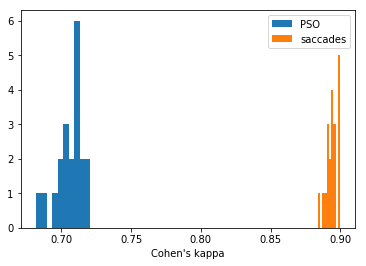

In [16]:
plt.hist(df_kappa['PSO'],label='PSO')
plt.hist(df_kappa['saccades'],label='saccades')
plt.xlabel("Cohen's kappa")
plt.legend()

In [12]:
print("Average Cohen's Kappa of U'n'Eye vs. both coders across trainings:")
display(df_kappa.median())

Average Cohen's Kappa of U'n'Eye vs. both coders across trainings:


network     9.500000
saccades    0.893598
PSO         0.709206
blinks      0.830362
dtype: float64